# Método de Bulirsch-Stoer

In [191]:
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt

# Método de Bulirsch-Stoer c/ Passo Fixo

In [192]:
def bulirsch(start: float, end: float, func: Callable, N: int, x0: (float | np.ndarray), eps: float) -> tuple[np.ndarray, np.ndarray]:
    """
        Resolve a EDO `dx/dt = func(x, t)` usando o método de Bulirsch-Stoer começando em `start` e terminando em `end` com `N` passos sendo `x(start) = x0` e sendo o erro total menor que `eps`.

        A função `func` deve aceitar dois argumentos: um float `x` e um float `t`. O argumento `x0` deve também ser `float`.

        ### Retorno
        tt: Array com os valores da variável independente `t`
        xx: Array com os resultados em função de `t`.
    """

    # Dá um passo de tamanho H usando o método do Ponto Médio Modificado começando em `start` e terminando em `end` com `N` passos intermédios sendo `x(start) = x0`.
    def pmediomod(start: float, end: float, func: Callable, N: int, x0: (float | np.ndarray)) -> (float | np.ndarray):
        # Passo
        h = (end - start) / N

        # Valor de x(t + h/2)
        xleap = x0 + h * func(x0, start) / 2

        xh = x0
        th = start
        for step in range(N):
            # Valor de x(t + h)
            xh = xh + h * func(xleap, th + h/2)
            th = th + h

            # Calcular valor de x(end)
            if step == N-1:
                xh = (xh + xleap + (h/2) * func(xh, th)) / 2
            
            # Calcular valor de x(t + h * 3/2) e guardar
            else:
                xleap = xleap + h * func(xh, th)
        
        return xh
    

    # Número de variáveis
    nvars = 1 if len(np.array(x0).shape) == 0 else len(np.array(x0))


    # Intervalos
    H = (end - start) / N
    tt = [start]
    xx = [x0]

    # Erro por unidade de tempo
    delta = eps / (end - start)

    # Erro alvo em cada passo
    erroalvo = H * delta

    tn = start
    xn = x0

    # Para passar da convenção algébrica para indíces de Python temos de usar n+1 e m+1 quando formos trabalhar com n e m como números (não como índices)
    for _ in range(N):
        # Valor de n para calcular R_{n+1, 1}
        n = 0

        # Linha anterior (começa como R_{1, 1})
        Ranterior = [pmediomod(tn, tn + H, func, n+1, xn)]
        n += 1

        # Linha atual
        Ratual = []

        erro = erroalvo + 1
        while abs(erro) > erroalvo:
            Ratual += [pmediomod(tn, tn + H, func, n+1, xn)]

            # Calcular R_{n+1, m+1}
            for m in range(n):
                errovars = (Ratual[m] - Ranterior[m]) / (((n+1)/n)**(2 * m + 2) - 1)
                Ratual += [Ratual[m] + errovars]

                if nvars == 1:
                    erro = errovars
                
                # ALTERAR DE ACORDO COM O PROBLEMA
                else:
                    erro = np.linalg.norm(errovars)


            n += 1

            # A linha atual passa a ser a linha anterior (fazer cópia)
            Ranterior = Ratual[:]
            Ratual = []

        # Atualizar os valores para a próxima iteração
        tn = tn + H
        xn = Ranterior[-1]

        # Guardar o valor de x(t + H)
        tt += [tn]
        xx += [xn]
    
    return np.array(tt), np.array(xx)

# Método de Bulirsch-Stoer c/ Passo Variável

In [193]:
def bulirschvar(start: float, end: float, func: Callable, N0: int, x0: (float | np.ndarray), eps: float, maxiter: int) -> tuple[np.ndarray, np.ndarray]:
    """
        Resolve o sistema de K EDOs `dx/dt = func(x, t)` usando o método de Bulirsch-Stoer começando em `start` e terminando em `end` sendo `x(start) = x0` com o erro total menor que `eps` e começando com `N0` passos, que pode variar de modo a que o número máximo de iterações num passo seja menor que `maxiter`.

        A função `func` deve aceitar dois argumentos: um array `x` com K entradas e um float `t`. O argumento `x0` deve também ter K entradas.

        ### Retorno
        tt: Array com os valores da variável independente `t`
        xx: Array com os resultados em função de `t` sendo que para K > 1 cada elemento do array é um array com o valor das várias funções em `t`.
    """

    # Número de variáveis
    nvars = 1 if len(np.array(x0).shape) == 0 else len(np.array(x0))


    # Dá um passo de tamanho H usando o método do Ponto Médio Modificado começando em `start` e terminando em `end` com `N` passos intermédios sendo `x(start) = x0`.
    def passoPMM(start: float, end: float, func: Callable, N: int, x0: (float | np.ndarray)) -> (float | np.ndarray):
        # Passo
        h = (end - start) / N

        # Valor de x(t + h/2)
        xleap = x0 + h * func(x0, start) / 2

        xh = x0
        th = start
        for step in range(N):
            # Valor de x(t + h)
            xh = xh + h * func(xleap, th + h/2)
            th = th + h

            # Calcular valor de x(end)
            if step == N-1:
                xh = (xh + xleap + (h/2) * func(xh, th)) / 2
            
            # Calcular valor de x(t + h * 3/2) e guardar
            else:
                xleap = xleap + h * func(xh, th)
        
        return xh

    # Dá um passo de tamanho H usando o método de Bulirsch-Stoer começando em `start` e terminando em `end` sem passos intermédios sendo `x(start) = x0`.
    def passoBS(start: float, H: float, func: Callable, x0: (float | np.ndarray), eps: float, maxiter: int) -> (float | np.ndarray):

        # Erro alvo em cada passo
        erroalvo = eps

        tn = start
        xn = x0

        # Para passar da convenção algébrica para indíces de Python temos de usar n+1 e m+1 quando formos trabalhar com n e m como números (não como índices)
        
        # Valor de n para calcular R_{n+1, 1}
        n = 0

        # Linha anterior (começa como R_{1, 1})
        Ranterior = [passoPMM(tn, tn + H, func, n+1, xn)]
        n += 1

        # Linha atual
        Ratual = []

        erro = erroalvo + 1
        while abs(erro) > erroalvo:
            if n > maxiter:
                raise ValueError("O número de passos foi demasiado grande!")

            Ratual += [passoPMM(tn, tn + H, func, n+1, xn)]

            # Calcular R_{n+1, m+1}
            for m in range(n):
                errovars = (Ratual[m] - Ranterior[m]) / (((n+1)/n)**(2 * m + 2) - 1)
                Ratual += [Ratual[m] + errovars]

                if nvars == 1:
                    erro = errovars
                
                # ALTERAR DE ACORDO COM O PROBLEMA
                else:
                    erro = np.linalg.norm(errovars)

            n += 1

            # A linha atual passa a ser a linha anterior (fazer cópia)
            Ranterior = Ratual[:]
            Ratual = []

        # Atualizar os valores para a próxima iteração
        xn = Ranterior[-1]
        
        return xn


    # Erro por unidade de tempo
    delta = eps / (end - start)

    # Intervalos
    tt = list(np.linspace(start, end, N0 + 1))
    xx = [x0]
    
    # Posição do índice
    i = 0
    while i < len(tt) - 1:
        # Valores no passo i
        H = tt[i + 1] - tt[i]
        tn = tt[i]
        xn = xx[i]

        # Conseguimos calcular o passo em menos iterações que o máximo
        try:
            xn = passoBS(tn, H, func, xn, delta * H, maxiter)
            xx += [xn]
            i += 1

        # Não conseguimos :(
        except ValueError:
            # Dividir o intervalo a meio
            tt.insert(i + 1, tn + H/2)
    
    return np.array(tt), np.array(xx)

## Testar os Métodos

Vamos verificar que os métodos funcionam, considerando a seguinte equação diferencial:

$$
\frac{dx}{dt} = -0.5x \quad\quad x(0) = 1
$$

Cuja solução exata é:

$$
x(t) = e^{-0.5t}
$$

In [194]:
# Lado direito da equação
def f(x, t):
    return -0.5 * x

# Solução exata
def exato(t):
    return np.exp(-0.5 * t)


# Parâmetro
a, b = 0, 10


tt = np.linspace(a, b, 1000)
xx = exato(tt)

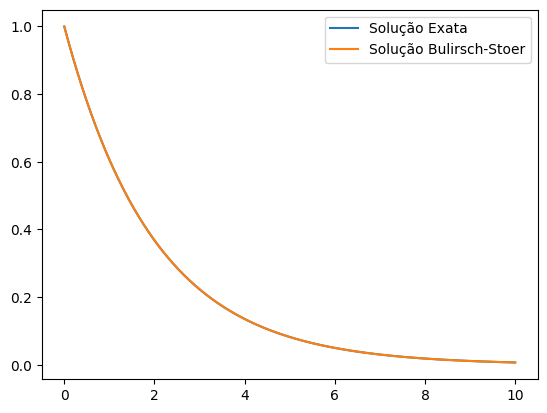

In [195]:
ttb, xxb = bulirsch(a, b, f, 1000, 1, 1e-5)

plt.plot(tt, xx, label="Solução Exata")
plt.plot(ttb, xxb, label="Solução Bulirsch-Stoer")
plt.legend()
plt.show()

# Podemos perceber a divergência se no cógido deste método também devolvermos os valores de x(t) nos pontos intermédios. Vemos que o método diverge de forma semelhante ao método de Euler!

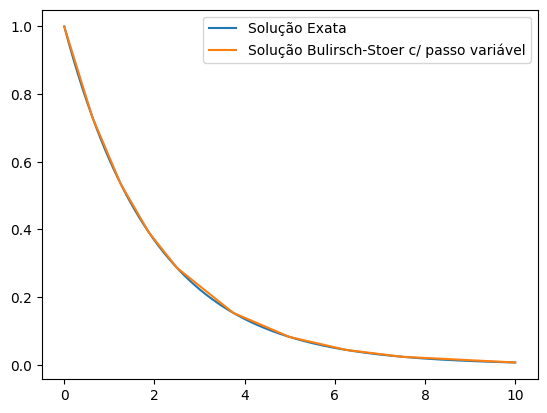

In [196]:
ttbv, xxbv = bulirschvar(a, b, f, 1, 1, 1e-5, 3)

plt.plot(tt, xx, label="Solução Exata")
plt.plot(ttbv, xxbv, label="Solução Bulirsch-Stoer c/ passo variável")
plt.legend()
plt.show()

# Testar para Sistemas de ODEs

Com base no exercício 2. da ficha 7

In [197]:
def f(r: np.ndarray, t: float) -> np.ndarray:
    alpha, beta, gamma, delta = 1, 0.5, 0.5, 2
    x, y = r[0], r[1]

    return np.array([alpha * x - beta * x * y, gamma * x * y - delta * y])

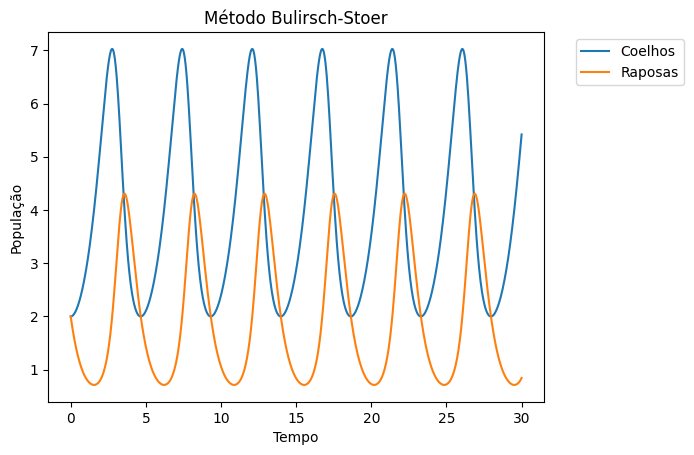

In [198]:
tt, sol = bulirsch(0, 30, f, 1000, np.array([2.0, 2.0]), 0.001)
xx = np.array([item[0] for item in sol])
yy = np.array([item[1] for item in sol])

plt.title("Método Bulirsch-Stoer")
plt.plot(tt, xx, label="Coelhos")
plt.plot(tt, yy, label="Raposas")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel("Tempo")
plt.ylabel("População")
plt.show()

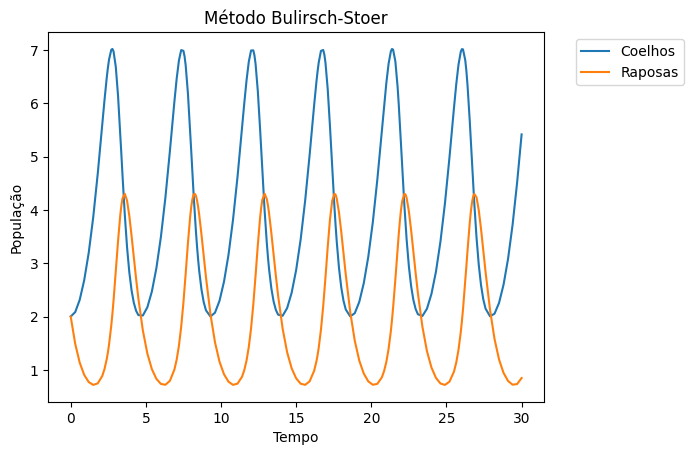

In [199]:
tt, sol = bulirschvar(0, 30, f, 100, np.array([2.0, 2.0]), 1e-10, 10)
xx = np.array([item[0] for item in sol])
yy = np.array([item[1] for item in sol])

plt.title("Método Bulirsch-Stoer")
plt.plot(tt, xx, label="Coelhos")
plt.plot(tt, yy, label="Raposas")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel("Tempo")
plt.ylabel("População")
plt.show()